In [ ]:
# =======================================
# FUNDAMENTALS
# =======================================
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# =======================================
# TENSORFLOW / KERAS
# =======================================
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision

# =======================================
# SCIKIT-LEARN
# =======================================
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# =======================================
# RANDOMNESS
# =======================================
random.seed(42)
tf.random.set_seed(42)

# =======================================
# PERFORMANCE OPTIMIZATION
# =======================================
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)


# About the Model

This model follows a classic CNN design with three convolutional blocks.
Each block combines convolution with Batch Normalization to keep training stable, and a MaxPooling layer to cut down on parameters while focusing on the most important features.
After these blocks, the extracted features are passed to a simple classification head that makes the final prediction.

<a id='1'></a>
## 1. Reading the Data

In [2]:
data = pd.read_csv("/kaggle/input/breast-cancer-paths/breast_paths_labels.csv")
data.head()

,path,label
0,/kaggle/input/breast-histopathology-images/IDC...,0
1,/kaggle/input/breast-histopathology-images/IDC...,0
2,/kaggle/input/breast-histopathology-images/IDC...,0
3,/kaggle/input/breast-histopathology-images/IDC...,0
4,/kaggle/input/breast-histopathology-images/IDC...,0


In [3]:
target_size = (50, 50)
batch_size = 128 
AUTOTUNE = tf.data.AUTOTUNE

#split the data (70-15-15)
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data["label"])
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42, stratify=val_data["label"])


def make_ds(df, training):
    """
    Build a `tf.data.Dataset` pipeline from a pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with two required columns:
            - "path": string paths to image files
            - "label": numeric labels (e.g., 0/1 for binary classification)
        training (bool): If True, applies shuffling and caching suitable for training.
                         If False, skips shuffling and caching for validation/testing.

    Returns:
        tf.data.Dataset: A dataset yielding batches of (image, label) pairs,
                         preprocessed for MobileNet (rescaled and resized).

    Notes:
        - Uses `tf.image.decode_jpeg` for fast image decoding.
        - Applies resizing and MobileNet-specific preprocessing.
        - Enables non-deterministic order (`experimental_deterministic=False`) for higher throughput.
        - Utilizes `AUTOTUNE` for parallel mapping and prefetching to maximize pipeline efficiency.
    """
    paths = df["path"].astype(str).values
    labels = df["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    #for more efficient usage of time
    options = tf.data.Options()
    options.experimental_deterministic = False
    ds = ds.with_options(options)

    if training:
        ds = ds.shuffle(buffer_size=min(len(df), 10000), reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        return img, tf.cast(label, tf.float32)

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.cache()

    ds = ds.batch(batch_size, drop_remainder=training)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_data, training=True)
val_ds   = make_ds(val_data,   training=False)
test_ds  = make_ds(test_data,  training=False)


In [4]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.label),
    y=train_data.label)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Classes:",np.unique(train_data.label))
print("Class weights:",class_weights)

Classes: [0 1]
Class weights: [0.69821588 1.76125113]


<a id='2'></a>
## 2. Training the Model

In [5]:
def train_convnet(units, learning_rate):
    model = tf.keras.Sequential()
   
    # 1. block
    model.add(layers.Conv2D(units, (9, 9), input_shape=(50, 50, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    # 2. block
    model.add(layers.Conv2D(units*2, (6, 6)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # 3. block
    model.add(layers.Conv2D(units*4, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    
    #Add classification head
    model.add(layers.Dense(10))
    model.add(layers.Activation("relu"))
    model.add(layers.Dense(1, activation='sigmoid', dtype='float32')) 

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision(name='prec'),
                 tf.keras.metrics.Recall(name='rec'),
                 tf.keras.metrics.AUC()],
                 jit_compile=True)

    #callbacks
    es = tf.keras.callbacks.EarlyStopping(
        patience=5, min_delta=0.001, restore_best_weights=True)
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, verbose=1)

 

    history = model.fit(train_ds, validation_data=val_ds, epochs=300,
                        callbacks=[es,rlrop],
                        class_weight=class_weight_dict,
                        )
    
    test_results = model.evaluate(test_ds)
    
    return model, history, test_results


In [6]:
params = {
    'learning_rate': 0.001,
    'units': 64
}
model, history, test_results = train_convnet(**params)

Epoch 1/300
1517/1517 [==============================] - 406s 259ms/step - loss: 0.4104 - prec: 0.6642 - rec: 0.8062 - auc: 0.8949 - val_loss: 1.0273 - val_prec: 0.8165 - val_rec: 0.1555 - val_auc: 0.8073 - lr: 0.0010
Epoch 2/300
1517/1517 [==============================] - 30s 19ms/step - loss: 0.3702 - prec: 0.6804 - rec: 0.8392 - auc: 0.9150 - val_loss: 0.9383 - val_prec: 0.8856 - val_rec: 0.0301 - val_auc: 0.8286 - lr: 0.0010
Epoch 3/300
1517/1517 [==============================] - 30s 20ms/step - loss: 0.3550 - prec: 0.6957 - rec: 0.8446 - auc: 0.9220 - val_loss: 0.8740 - val_prec: 0.8226 - val_rec: 0.0086 - val_auc: 0.7735 - lr: 0.0010
Epoch 4/300
1517/1517 [==============================] - 30s 20ms/step - loss: 0.3467 - prec: 0.6992 - rec: 0.8498 - auc: 0.9257 - val_loss: 1.2446 - val_prec: 0.6195 - val_rec: 0.0118 - val_auc: 0.7497 - lr: 0.0010
Epoch 5/300
1517/1517 [==============================] - 31s 20ms/step - loss: 0.3398 - prec: 0.7019 - rec: 0.8552 - auc: 0.9287 - val

In [7]:
model.save_weights('cnn_model.h5')

with open('cnn_model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
with open('cnn_test_results.pkl', 'wb') as file:
    pickle.dump(test_results, file)

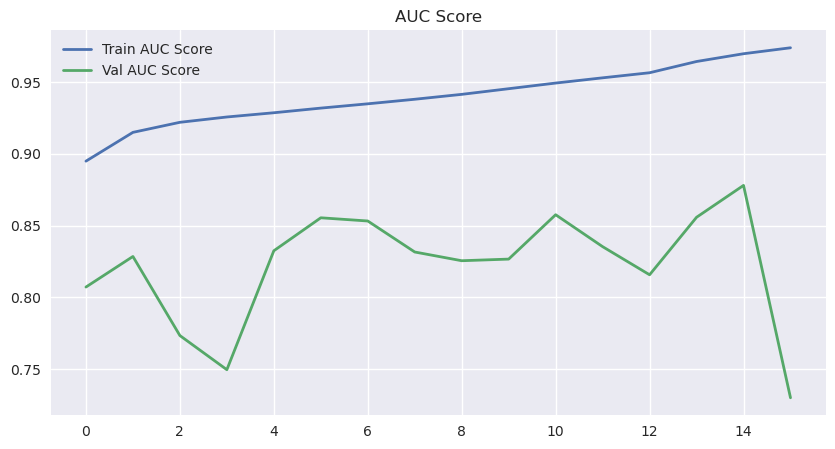

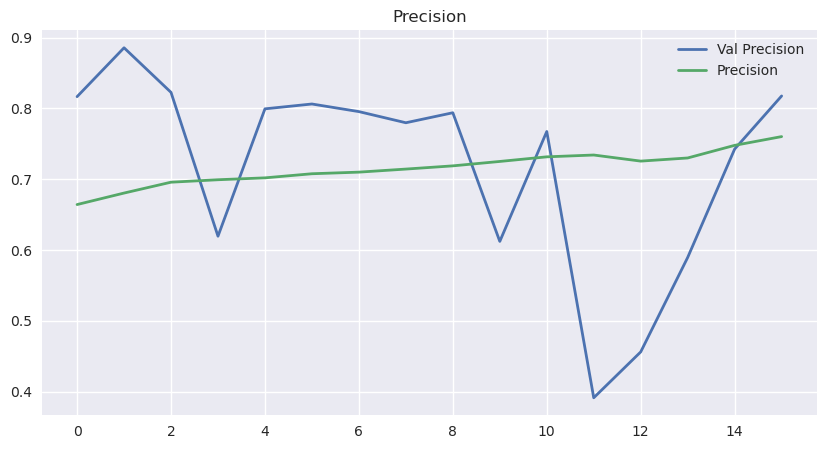

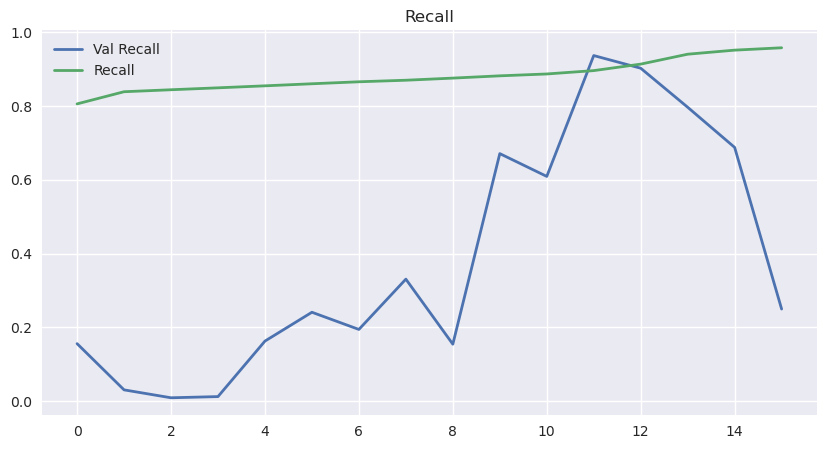

In [8]:
def plot_the_results(history):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['auc'], label = 'Train AUC Score',linewidth=2)
    plt.plot(history.epoch,history.history['val_auc'], label = 'Val AUC Score',linewidth=2)
    plt.legend()
    plt.title('AUC Score')
    plt.show()

    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_prec'], label = 'Val Precision',linewidth=2)
    plt.plot(history.epoch,history.history['prec'], label = 'Precision',linewidth=2)
    plt.legend()
    plt.title('Precision')
    plt.show()
    
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_rec'], label = 'Val Recall',linewidth=2)
    plt.plot(history.epoch,history.history['rec'], label = 'Recall',linewidth=2)
    plt.legend()
    plt.title('Recall')
    plt.show()
    
plot_the_results(history)

In [9]:
ls = test_results[0]
prec = test_results[1]
rec = test_results[2]
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

print("Test Results")
print("\n-------------\n")
print("Test Loss:",format(ls,'.3f'))
print("Test Precision: ",format(prec, '.3f'))
print("Test Recall: ", format(rec,'.3f'))
print("Test F1:", format(f1, '.3f'))

Test Results

-------------

Test Loss: 0.487
Test Precision:  0.769
Test Recall:  0.613
Test F1: 0.682


<a id='4'></a>
## 4. Calculating the Number of Parameters and Amount of Mult Adds Needed

In [10]:
total_parameters = model.count_params()
mult_adds_total = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        height, width, channels_in = layer.input_shape[1:]
        _, _, channels_out = layer.output_shape[1:]
        kernel_height, kernel_width = layer.kernel_size

        mult_adds = height * width * channels_in * channels_out * kernel_height * kernel_width
        mult_adds_total += mult_adds
        
        
print("Total parameters:", total_parameters)
print("Total number of multipy-accumulates:", mult_adds_total)

Total parameters: 630677
Total number of multipy-accumulates: 187810560
